In [1]:
import zarr
import allel
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')

/home/aliman/github/alimanfoo/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Setup

### Setup variation data 

In [2]:
callset_pass = zarr.open_consolidated('/kwiat/vector/ag1000g/release/phase2.AR1/variation/main/zarr/pass/ag1000g.phase2.ar1.pass', mode='r')
callset_pass

<zarr.hierarchy.Group '/' read-only>

In [3]:
dsx_region = '2R', 48_703_664 - 5_000, 48_788_460 + 5_000  # N.B., reverse strand; add 5 kbp upstream and downstream

In [4]:
pos = allel.SortedIndex(callset_pass[dsx_region[0]]['variants/POS'])
pos

<SortedIndex shape=(15425222,) dtype=int32>
[6822, 6833, 6856, 6862, 6863, ..., 61531765, 61531905, 61531908, 61532911, 61532915]

In [5]:
loc_dsx = pos.locate_range(dsx_region[1], dsx_region[2])
loc_dsx

slice(13892676, 13911235, None)

In [6]:
pos_dsx = pos[loc_dsx]
pos_dsx

<SortedIndex shape=(18559,) dtype=int32>
[48698665, 48698670, 48698675, 48698680, 48698681, ..., 48792241, 48792242, 48792244, 48792245, 48792257]

In [7]:
gt_dsx = allel.GenotypeArray(callset_pass[dsx_region[0]]['calldata/GT'][loc_dsx])
gt_dsx

<GenotypeArray shape=(18559, 1142, 2) dtype=int8>
0/1 0/1 1/1 1/1 0/0 ... 0/0 1/1 1/1 0/1 1/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/1 0/0 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/1

### Setup sample metadata

In [8]:
df_samples = pd.read_csv('/kwiat/vector/ag1000g/release/phase2.AR1/samples/samples.meta.txt', sep='\t')
df_samples.head()

ox_code         src_code population country       region    contributor  \
0  AA0040-C  Twifo_Praso__E2      GHcol   Ghana  Twifo_Praso  David Weetman   
1  AA0041-C  Twifo_Praso__H3      GHcol   Ghana  Twifo_Praso  David Weetman   
2  AA0042-C      Takoradi_C7      GHcol   Ghana     Takoradi  David Weetman   
3  AA0043-C      Takoradi_H8      GHcol   Ghana     Takoradi  David Weetman   
4  AA0044-C     Takoradi_D10      GHcol   Ghana     Takoradi  David Weetman   

  contact    year m_s sex  n_sequences  mean_coverage  
0     NaN  2012.0   M   F     95033368          30.99  
1     NaN  2012.0   M   F     95843804          31.70  
2     NaN  2012.0   M   F    107420666          35.65  
3     NaN  2012.0   M   F     95993752          29.46  
4     NaN  2012.0   M   F    103044262          33.67

In [9]:
populations = df_samples.population.unique()
populations

array(['GHcol', 'GHgam', 'BFgam', 'BFcol', 'UGgam', 'GM', 'GW', 'KE',
       'CMgam', 'FRgam', 'GQgam', 'AOcol', 'GAgam', 'GNgam', 'GNcol',
       'CIcol'], dtype=object)

In [10]:
len(populations)

16

### Compute allele counts

In [11]:
def subset_genotypes():
    global gt_dsx_pops
    gt_dsx_pops = dict()
    for pop in populations:
        loc_pop = df_samples[df_samples.population == pop].index.values
        gt_dsx_pops[pop] = gt_dsx.take(loc_pop, axis=1)

subset_genotypes()

In [12]:
gt_dsx_pops['GHcol']

<GenotypeArray shape=(18559, 55, 2) dtype=int8>
0/1 0/1 1/1 1/1 0/0 ... 0/0 0/1 0/0 1/1 1/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/1 0/0 0/1 0/0 ... 0/0 0/0 0/0 0/1 0/0

In [13]:
def compute_allele_counts():
    global ac_dsx_pops
    ac_dsx_pops = dict()
    for pop in populations:
        gt = gt_dsx_pops[pop]
        ac = gt.count_alleles(max_allele=3)
        ac_dsx_pops[pop] = ac

compute_allele_counts()

In [14]:
ac_dsx_pops['GHcol']

<AlleleCountsArray shape=(18559, 4) dtype=int32>
 61  49   0   0
110   0   0   0
110   0   0   0
...
106   4   0   0
110   0   0   0
102   8   0   0

### Setup accessibility

In [15]:
accessibility = h5py.File('/kwiat/vector/ag1000g/release/phase2.AR1/accessibility/accessibility.h5', mode='r')
is_accessible = accessibility[dsx_region[0]]['is_accessible'][:]
is_accessible

array([False, False, False, ..., False, False, False])

## Explore raw diversity data

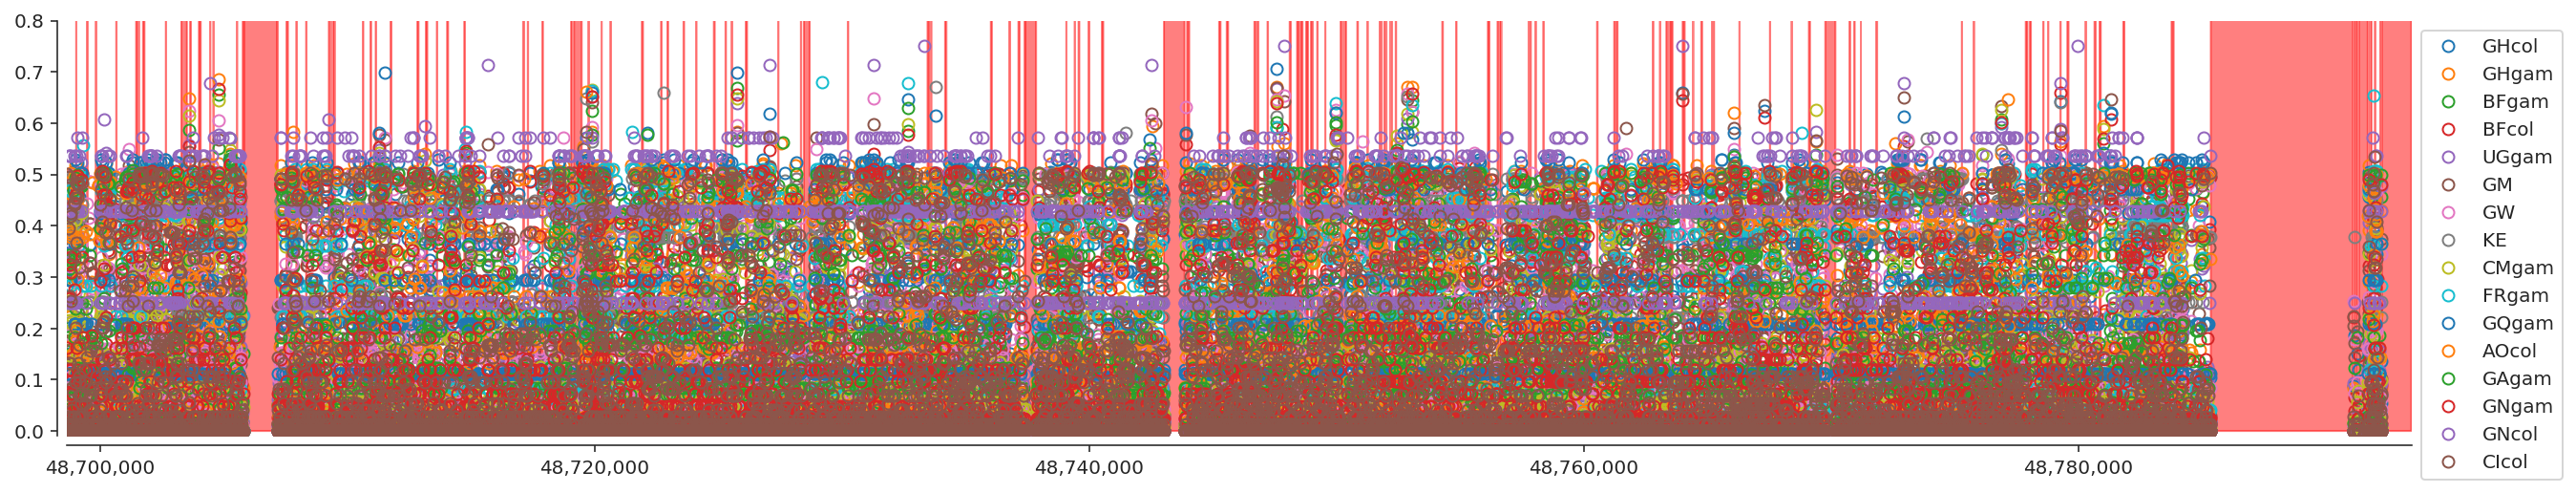

In [23]:
def plot_diversity_raw(xlim=dsx_region[1:], pops=populations):
    fig, ax = plt.subplots(figsize=(22, 4))
    sns.despine(ax=ax, offset=5)
    
    # plot diversity
    x = pos_dsx
    for pop in pops:
        ac = ac_dsx_pops[pop]
        y = allel.mean_pairwise_difference(ac)
        ax.plot(x, y, linestyle=' ', marker='o', mfc='none', label=pop)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
        
    # plot accessibility
    x = np.arange(xlim[0], xlim[1])
    y = 1 - is_accessible[xlim[0] - 1:xlim[1] - 1].astype('u1')
    ax.fill_between(x, 0, y, color='r', alpha=.5)
    
    # tidy up
    ax.set_xlim(*xlim)
    ax.set_ylim(-0.01, 0.8)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
    
plot_diversity_raw()

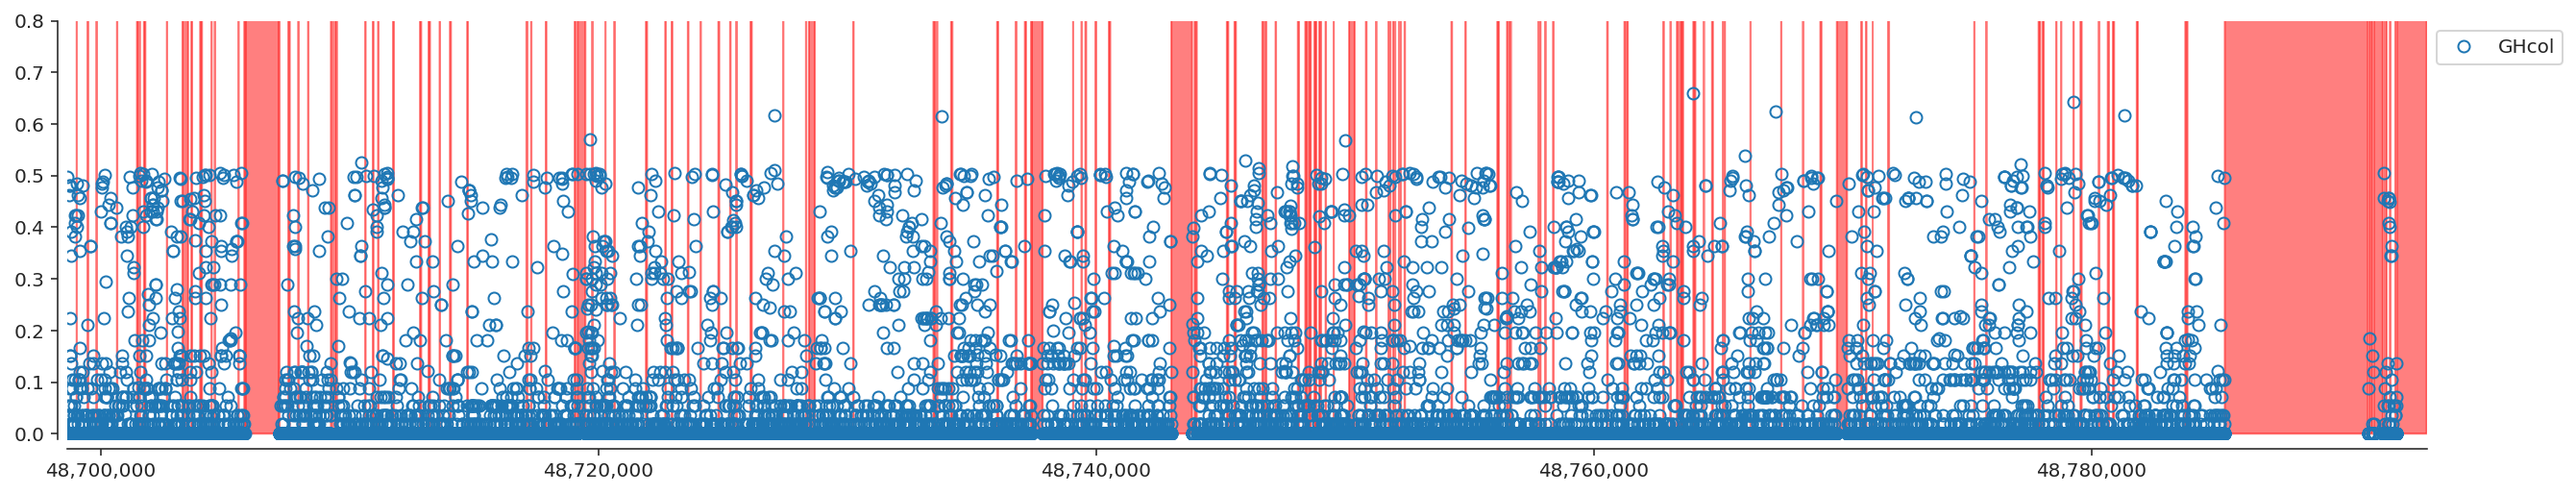

In [24]:
plot_diversity_raw(pops=['GHcol'])

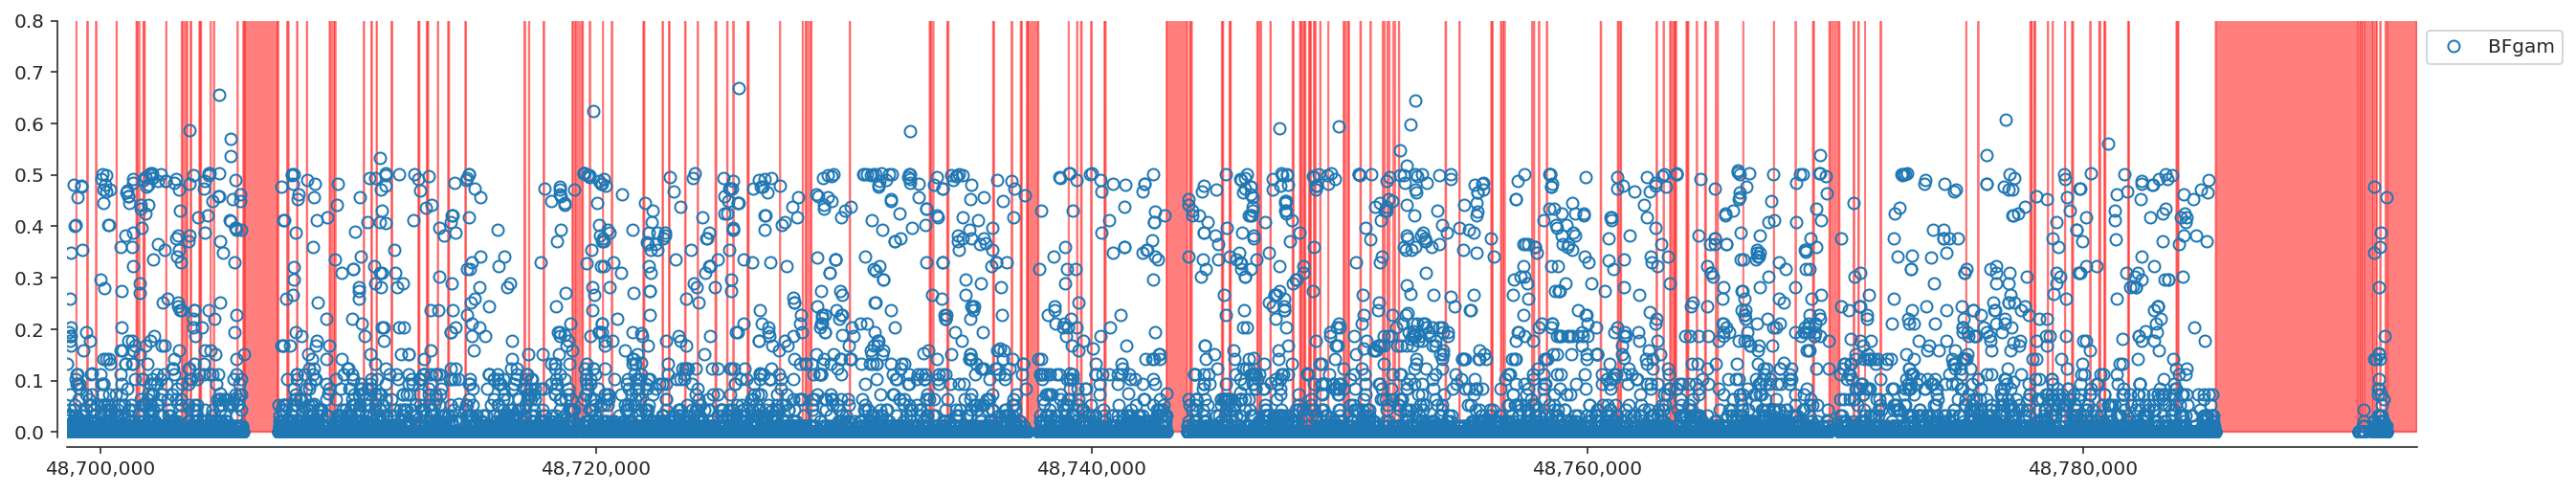

In [25]:
plot_diversity_raw(pops=['BFgam'])

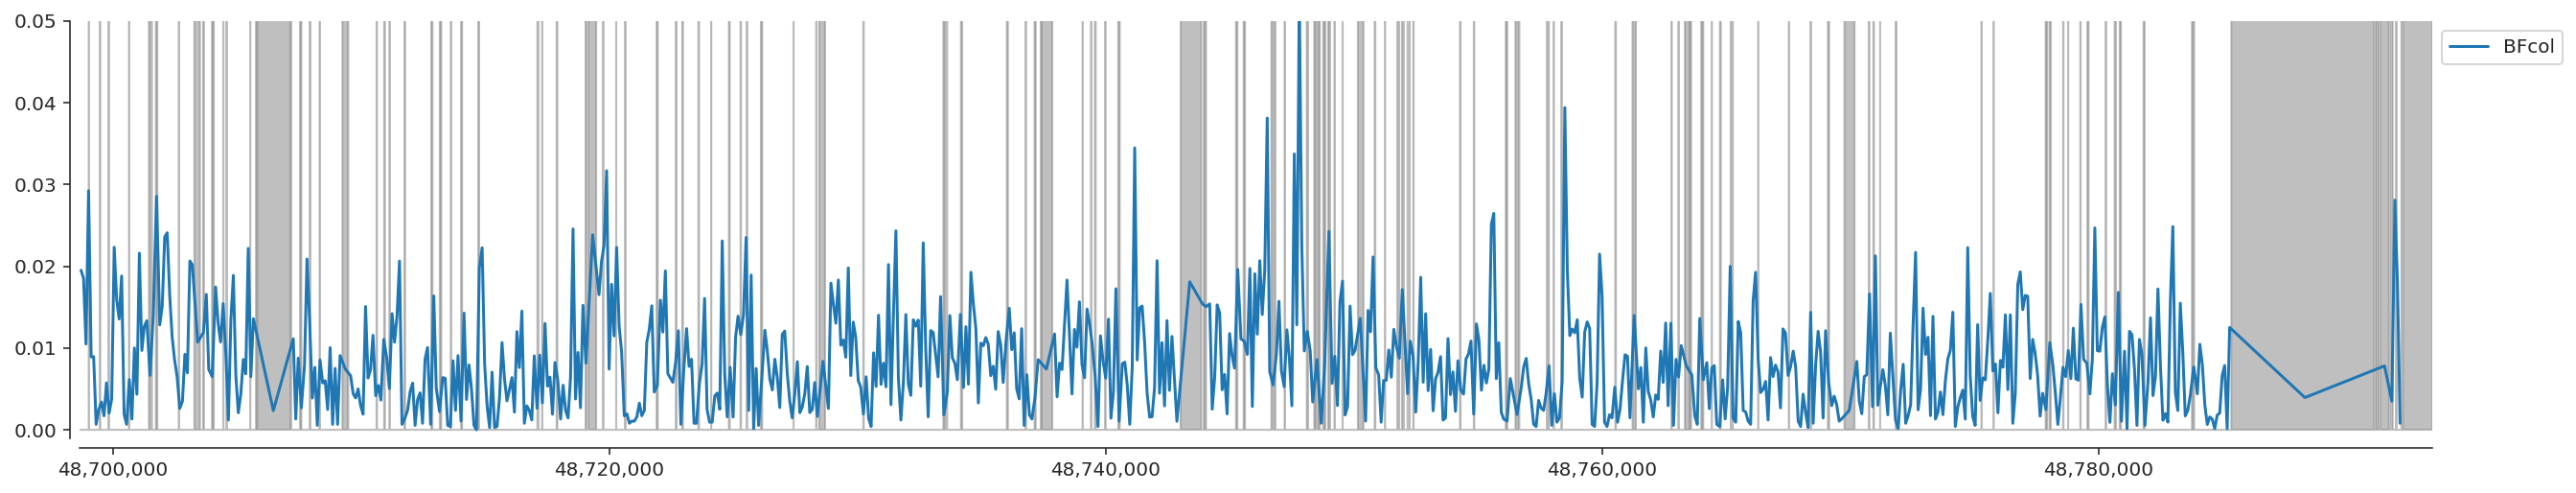

In [28]:
def plot_diversity_windowed(xlim=dsx_region[1:], pops=populations, window_size=100, window_step=None):
    fig, ax = plt.subplots(figsize=(22, 4))
    sns.despine(ax=ax, offset=5)
    
    # plot diversity
    windows = allel.equally_accessible_windows(is_accessible, size=window_size, start=xlim[0], stop=xlim[1], step=window_step)
    x = windows.mean(axis=1)
    for pop in pops:
        ac = ac_dsx_pops[pop]
        mpd = allel.mean_pairwise_difference(ac)
        y, _, _ = allel.windowed_statistic(pos_dsx, mpd, statistic=lambda v: np.sum(v) / window_size, windows=windows, fill=0)
        ax.plot(x, y, linestyle='-', marker=None, label=pop)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
        
    # plot accessibility
    x = np.arange(xlim[0], xlim[1])
    y = 1 - is_accessible[xlim[0] - 1:xlim[1] - 1].astype('u1')
    ax.fill_between(x, 0, y, color='grey', alpha=.5)
    
    # tidy up
    ax.set_xlim(*xlim)
    ax.set_ylim(-0.001, 0.05)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
    
plot_diversity_windowed(pops=['BFcol'])

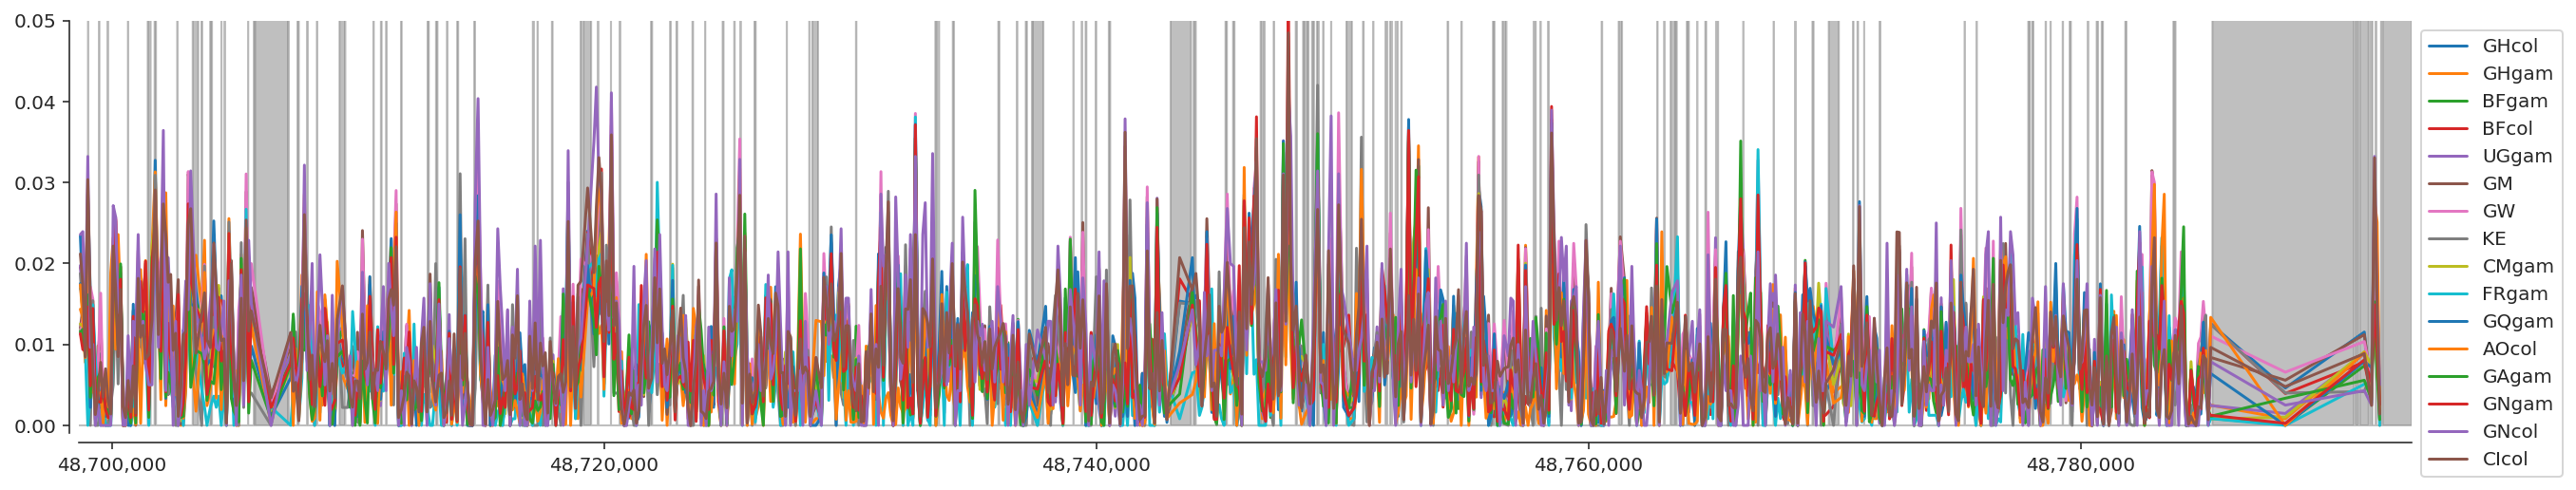

In [29]:
plot_diversity_windowed()

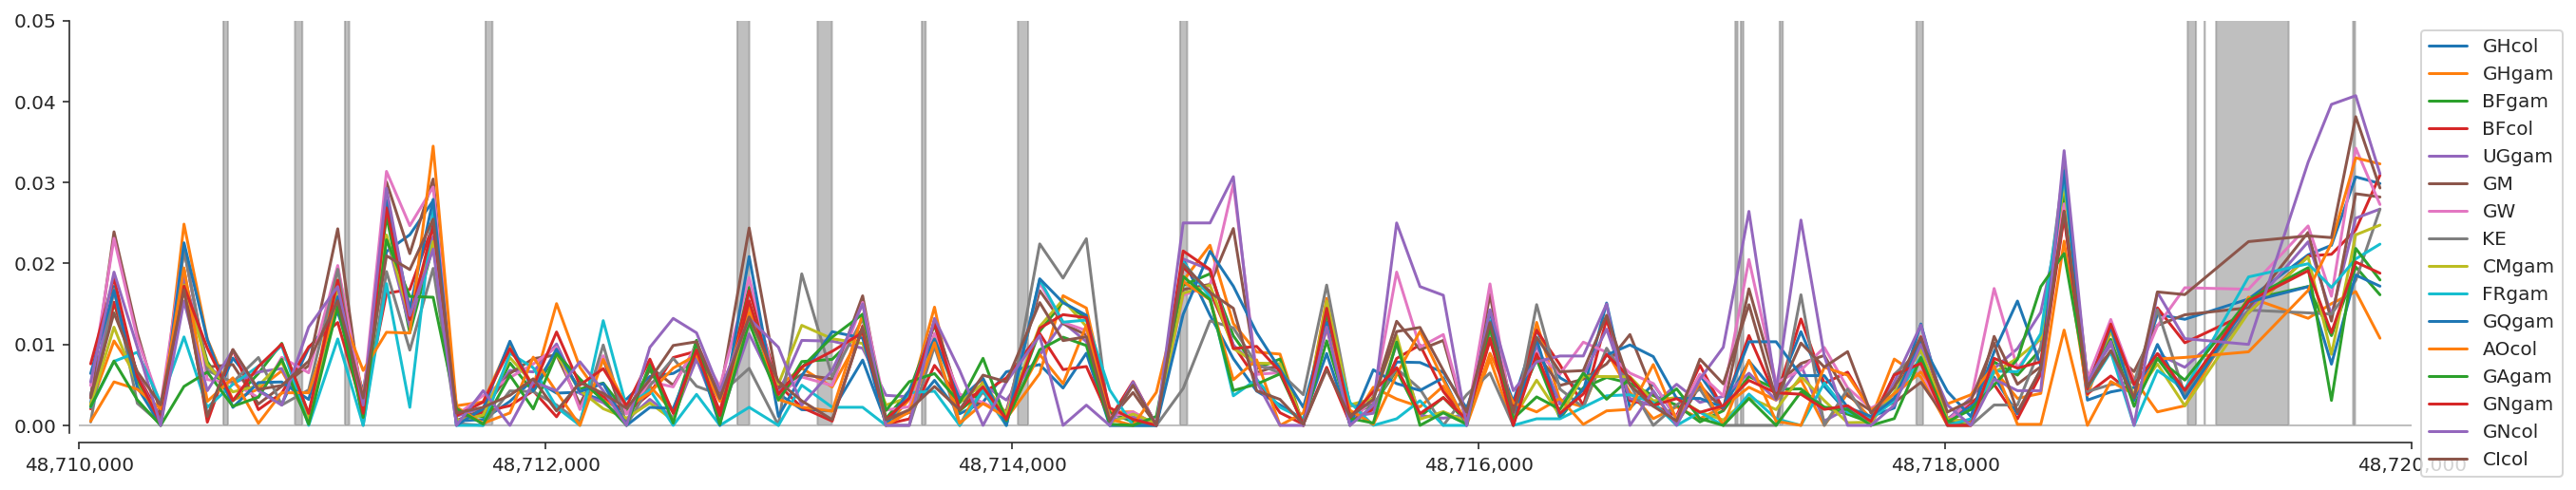

In [30]:
plot_diversity_windowed(xlim=(48_710_000, 48_720_000))

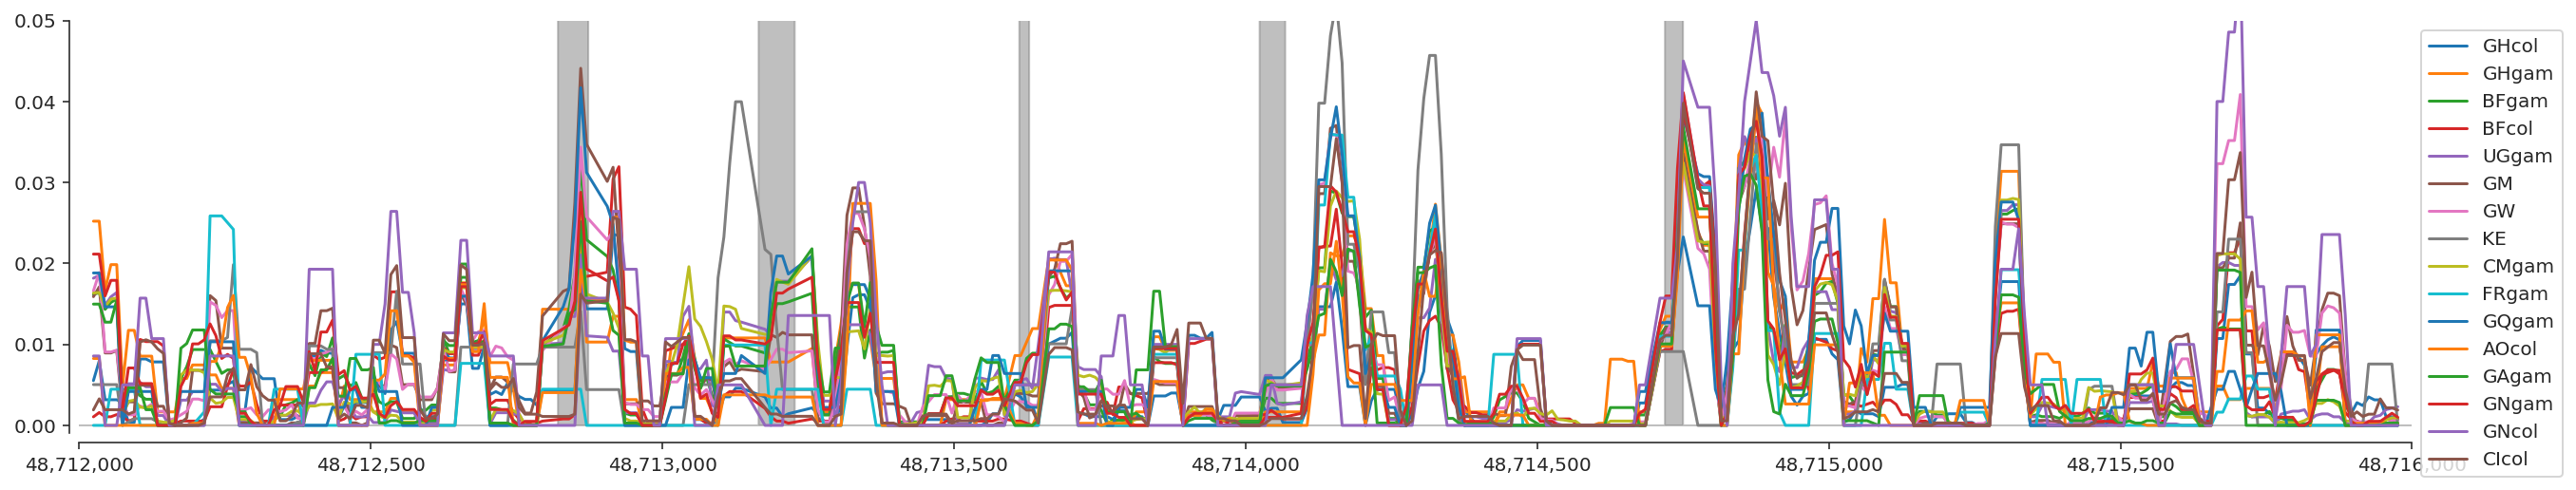

In [31]:
plot_diversity_windowed(xlim=(48_712_000, 48_716_000), window_size=50, window_step=10)

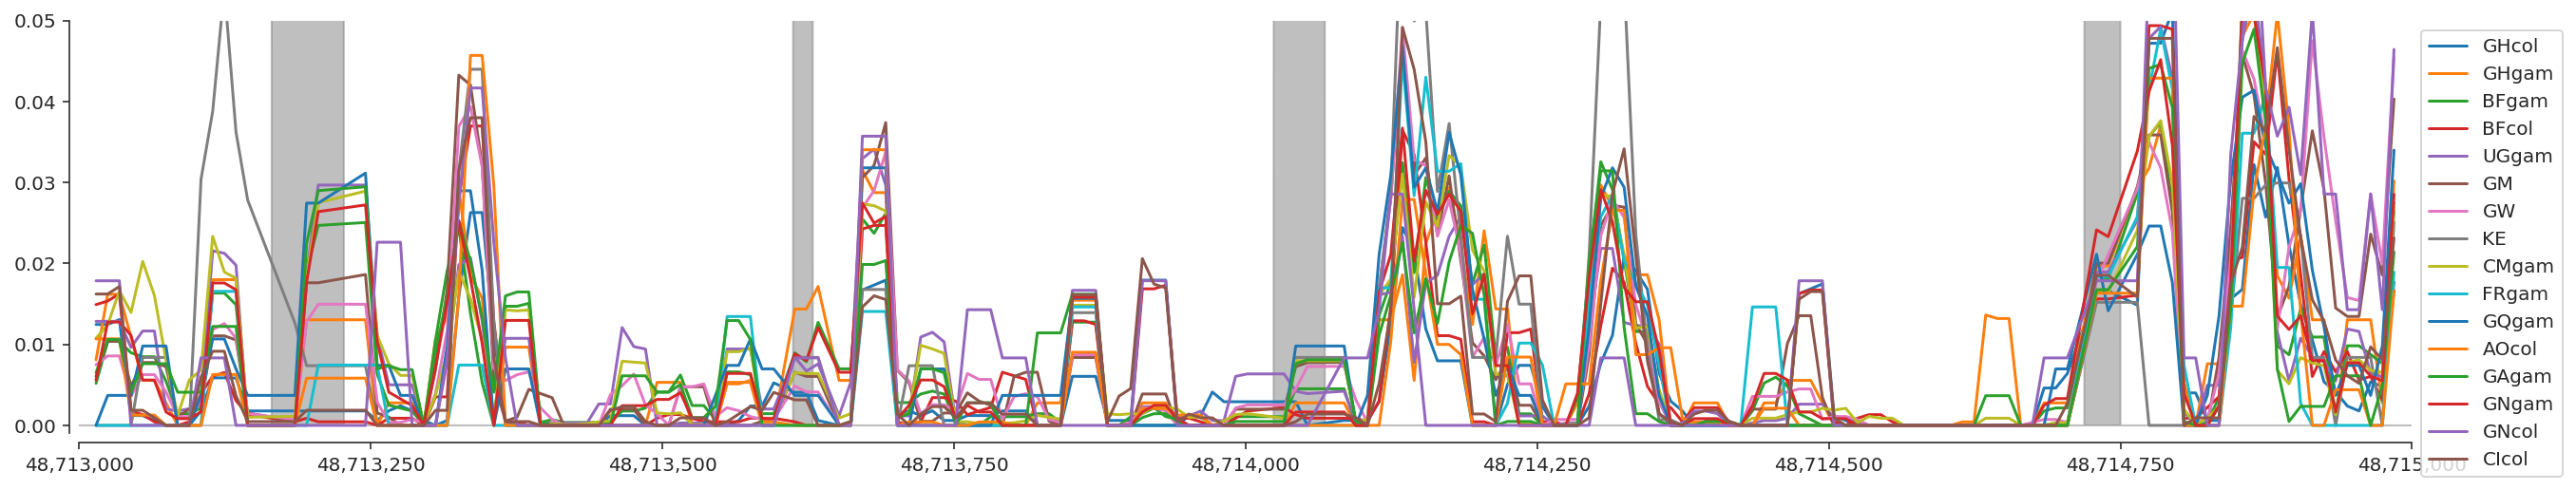

In [32]:
plot_diversity_windowed(xlim=(48_713_000, 48_715_000), window_size=30, window_step=10)

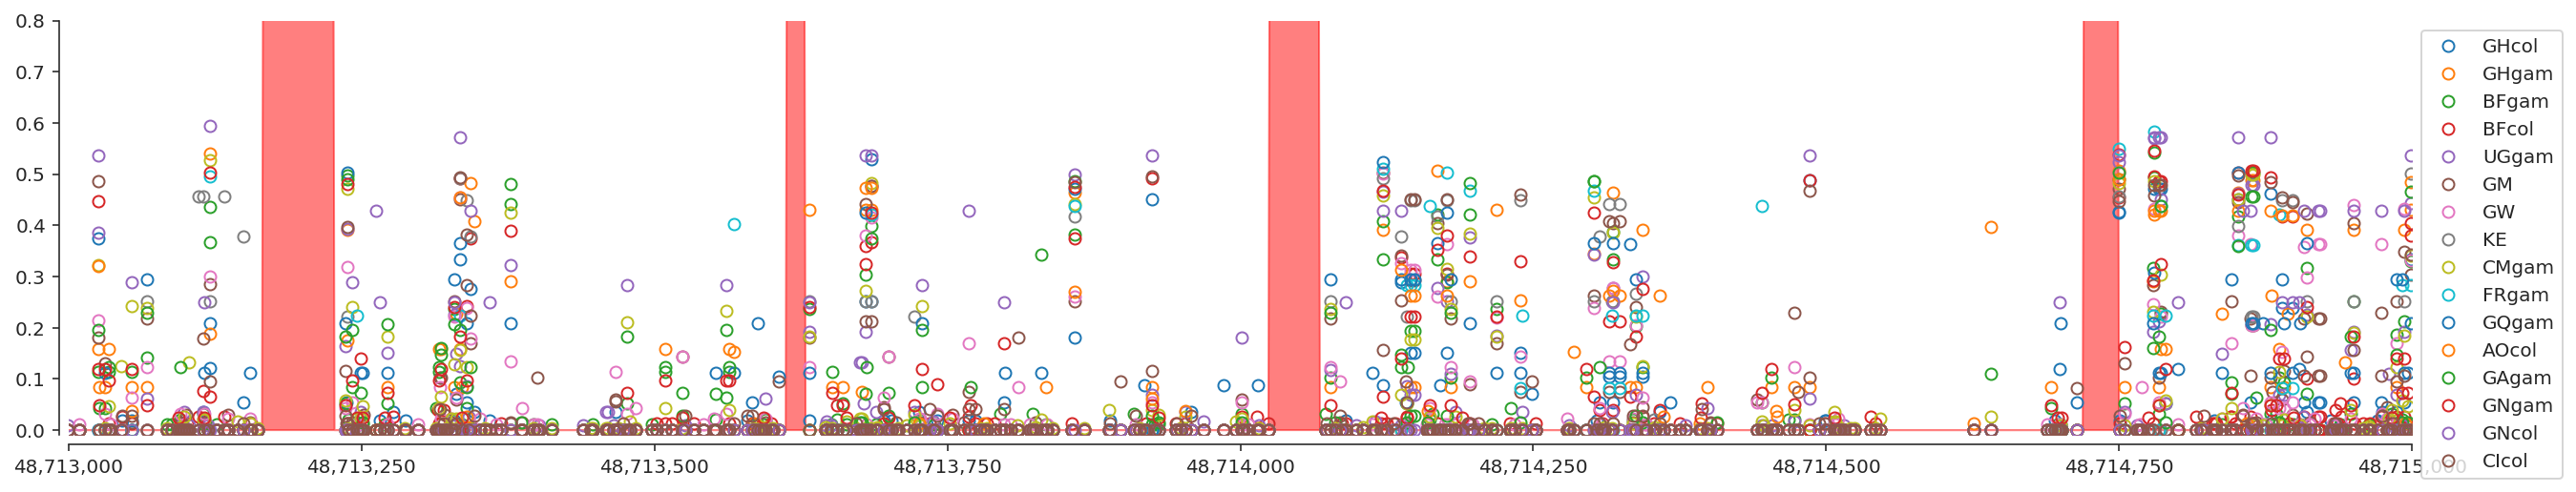

In [33]:
plot_diversity_raw(xlim=(48_713_000, 48_715_000))

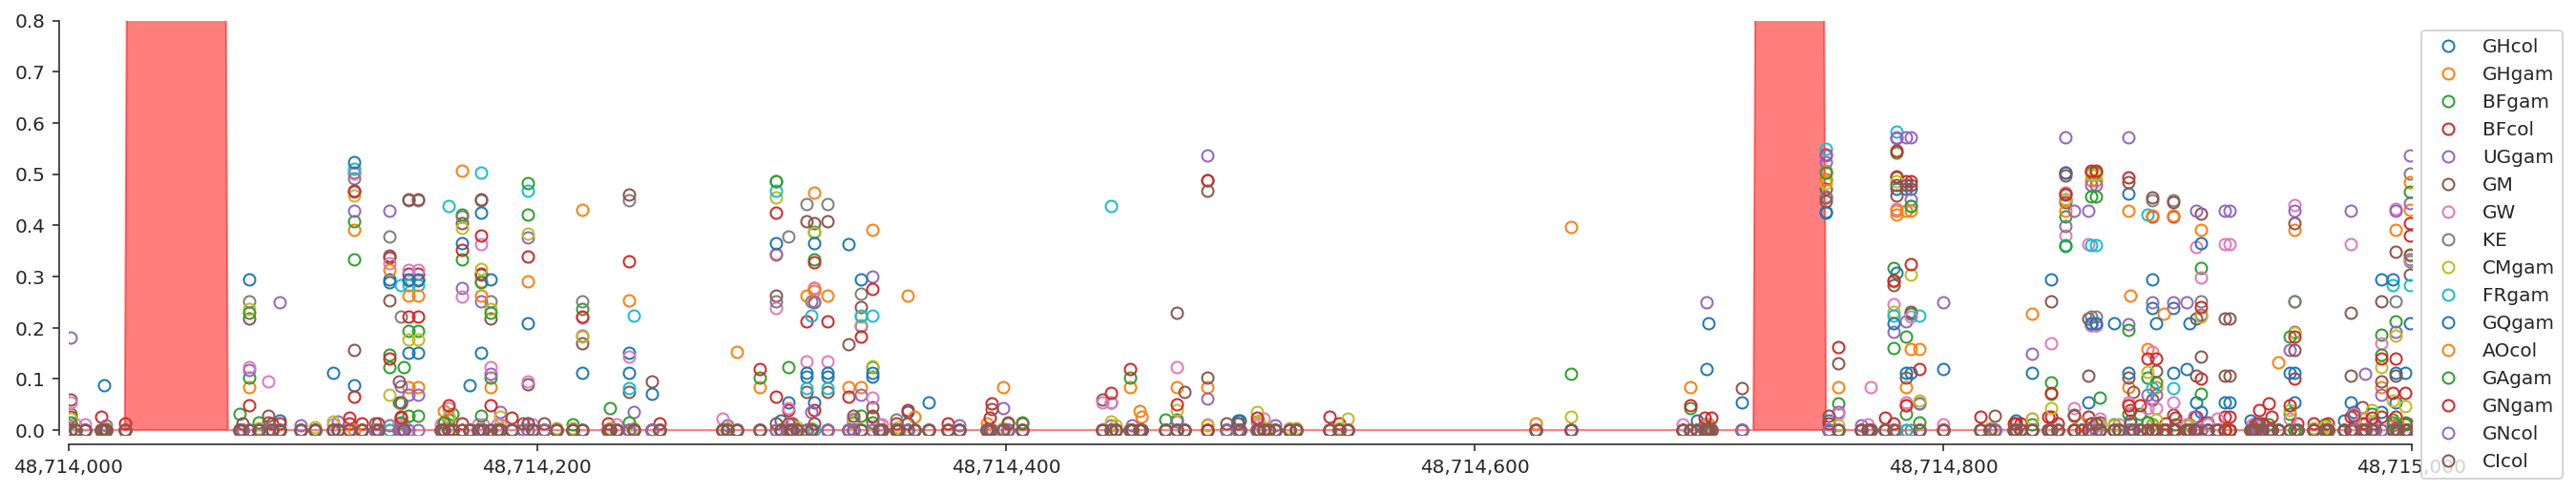

In [34]:
plot_diversity_raw(xlim=(48_714_000, 48_715_000))

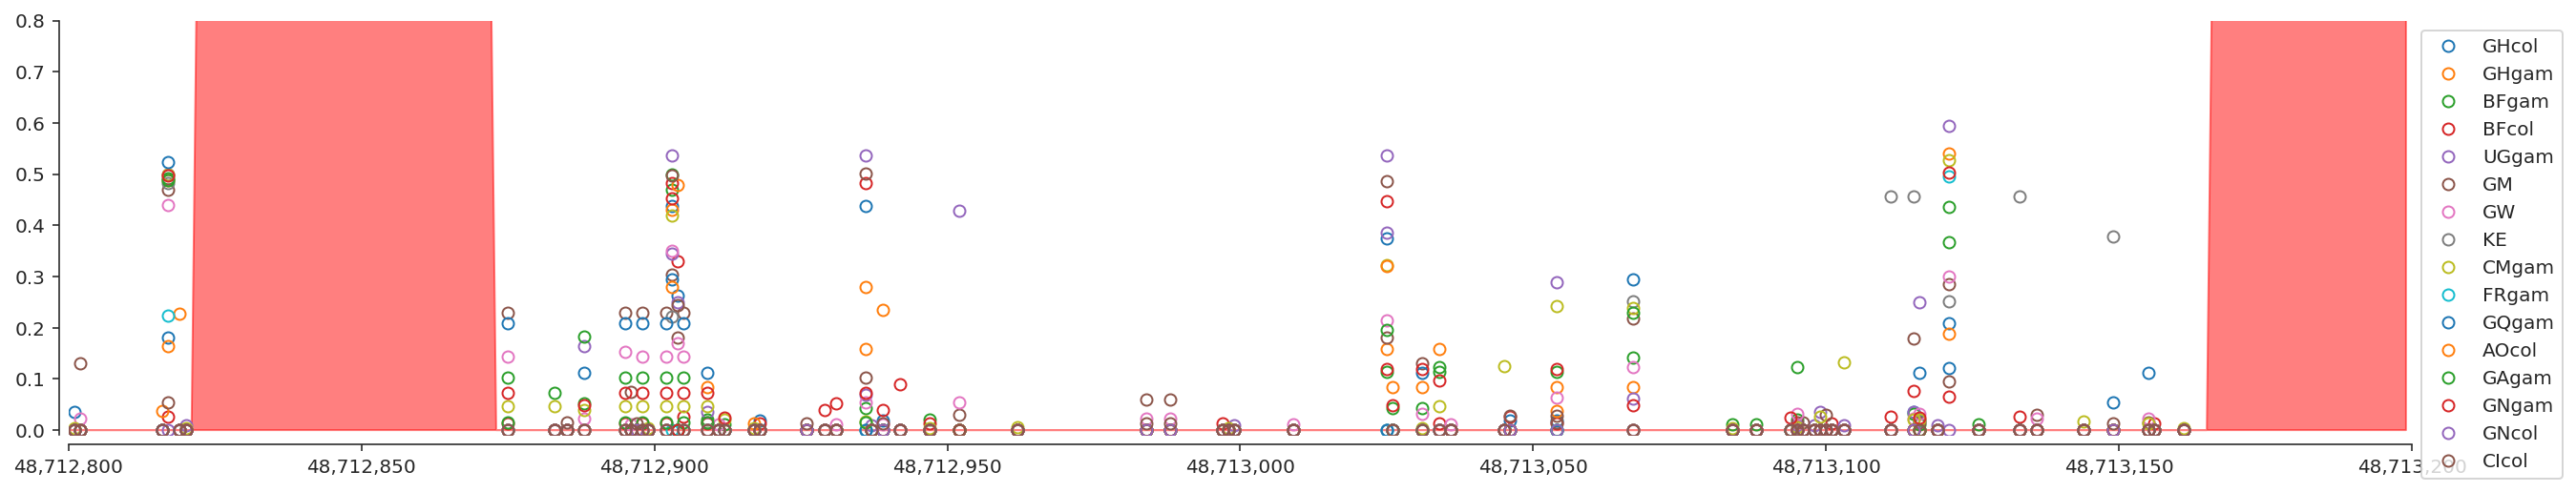

In [35]:
plot_diversity_raw(xlim=(48_712_800, 48_713_200))

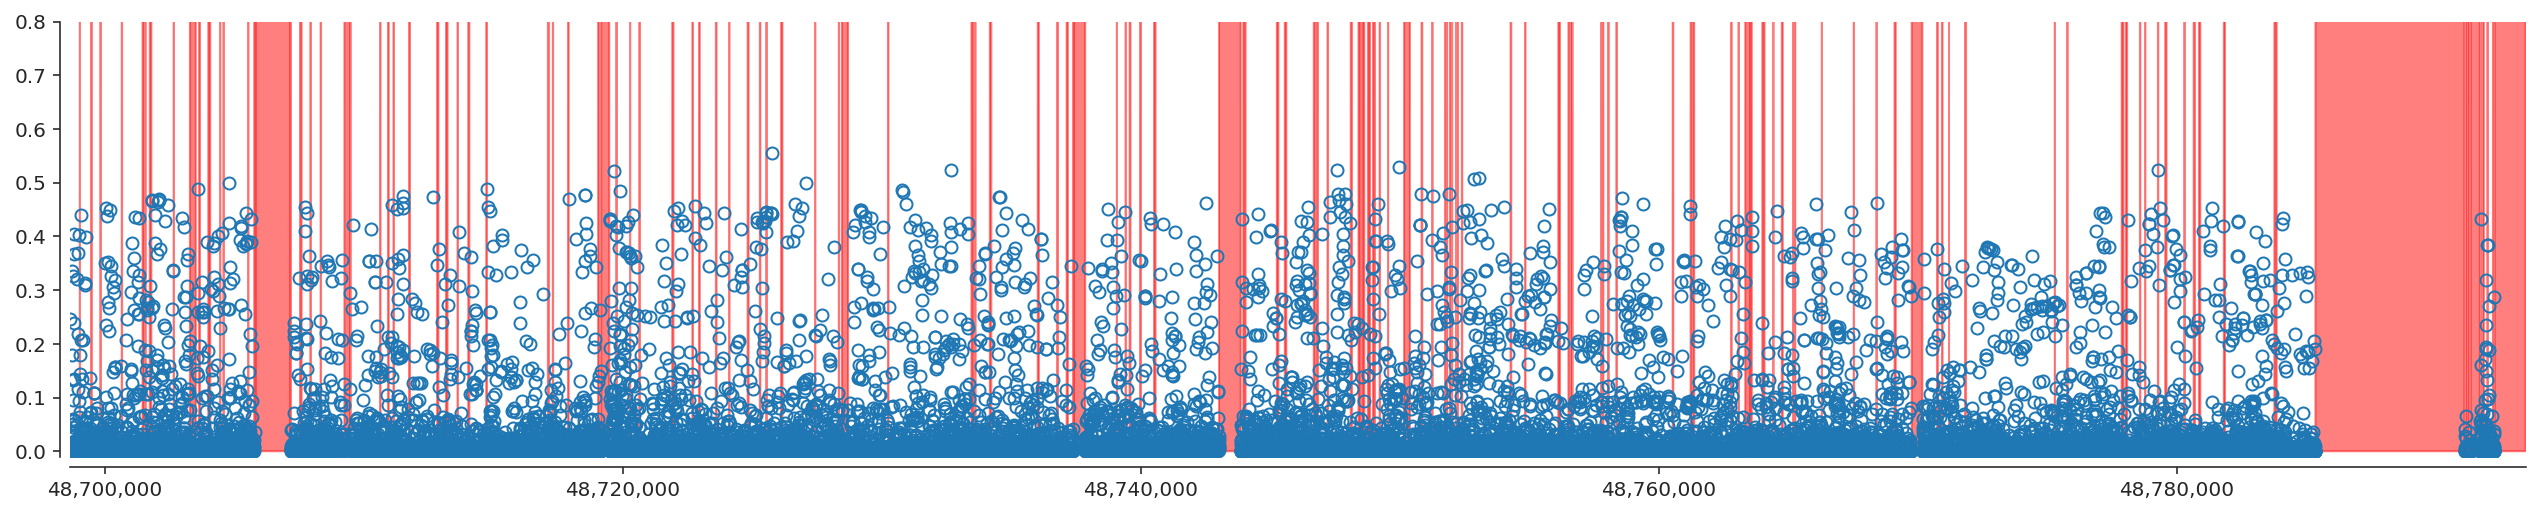

In [40]:
def plot_diversity_raw_mean(xlim=dsx_region[1:], pops=populations):
    fig, ax = plt.subplots(figsize=(22, 4))
    sns.despine(ax=ax, offset=5)
    
    # plot diversity
    x = pos_dsx
    ys = np.vstack([allel.mean_pairwise_difference(ac_dsx_pops[pop]) for pop in populations])
    y = np.mean(ys, axis=0)
    ax.plot(x, y, linestyle=' ', marker='o', mfc='none')
#    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
        
    # plot accessibility
    x = np.arange(xlim[0], xlim[1])
    y = 1 - is_accessible[xlim[0] - 1:xlim[1] - 1].astype('u1')
    ax.fill_between(x, 0, y, color='r', alpha=.5)
    
    # tidy up
    ax.set_xlim(*xlim)
    ax.set_ylim(-0.01, 0.8)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
    
plot_diversity_raw_mean()

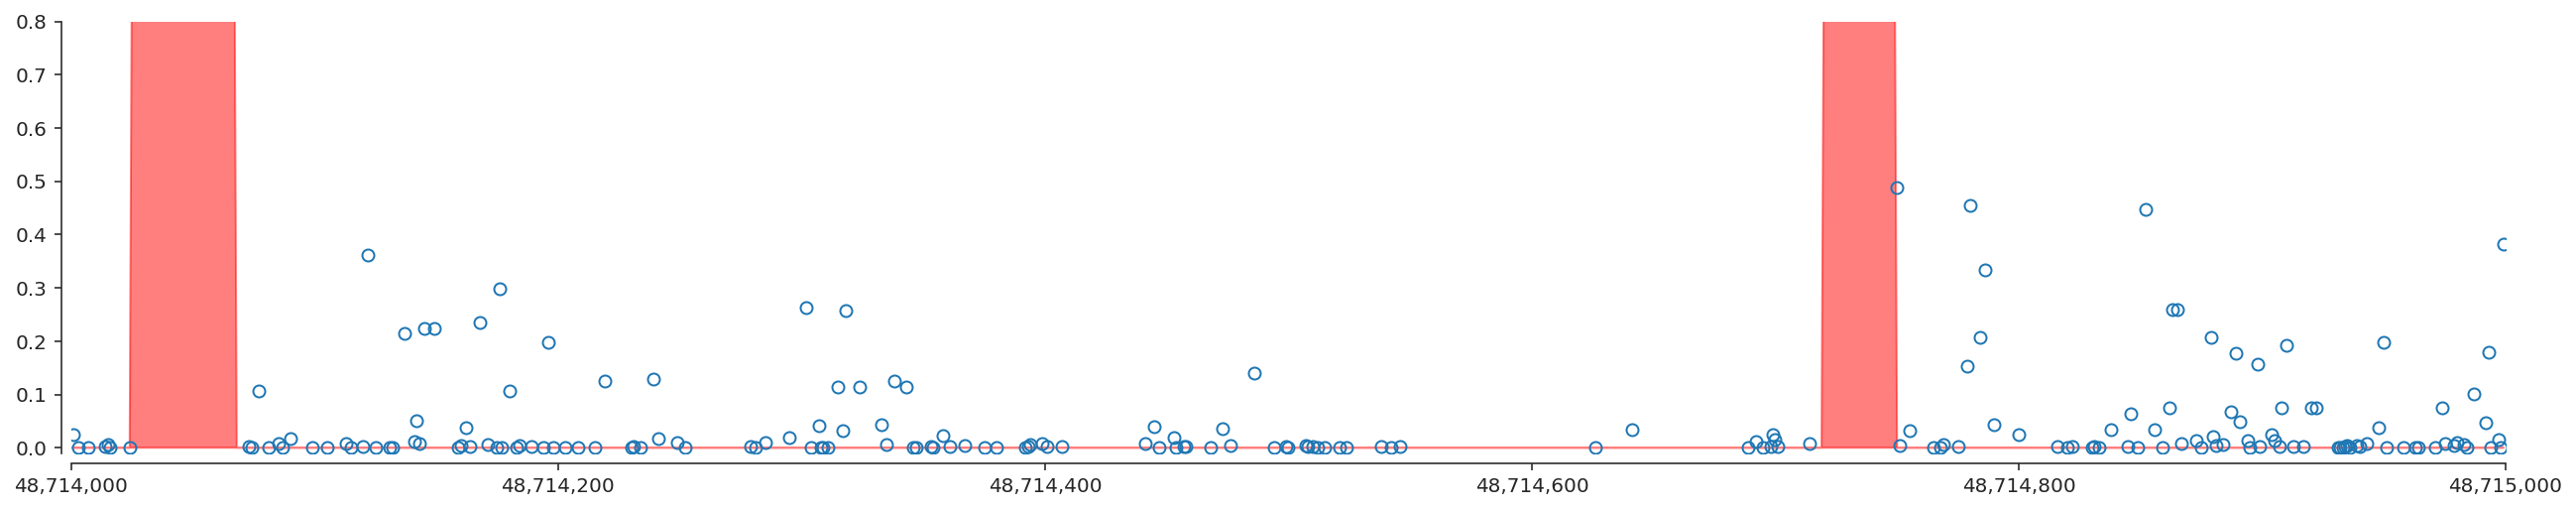

In [41]:
plot_diversity_raw_mean(xlim=(48_714_000, 48_715_000))

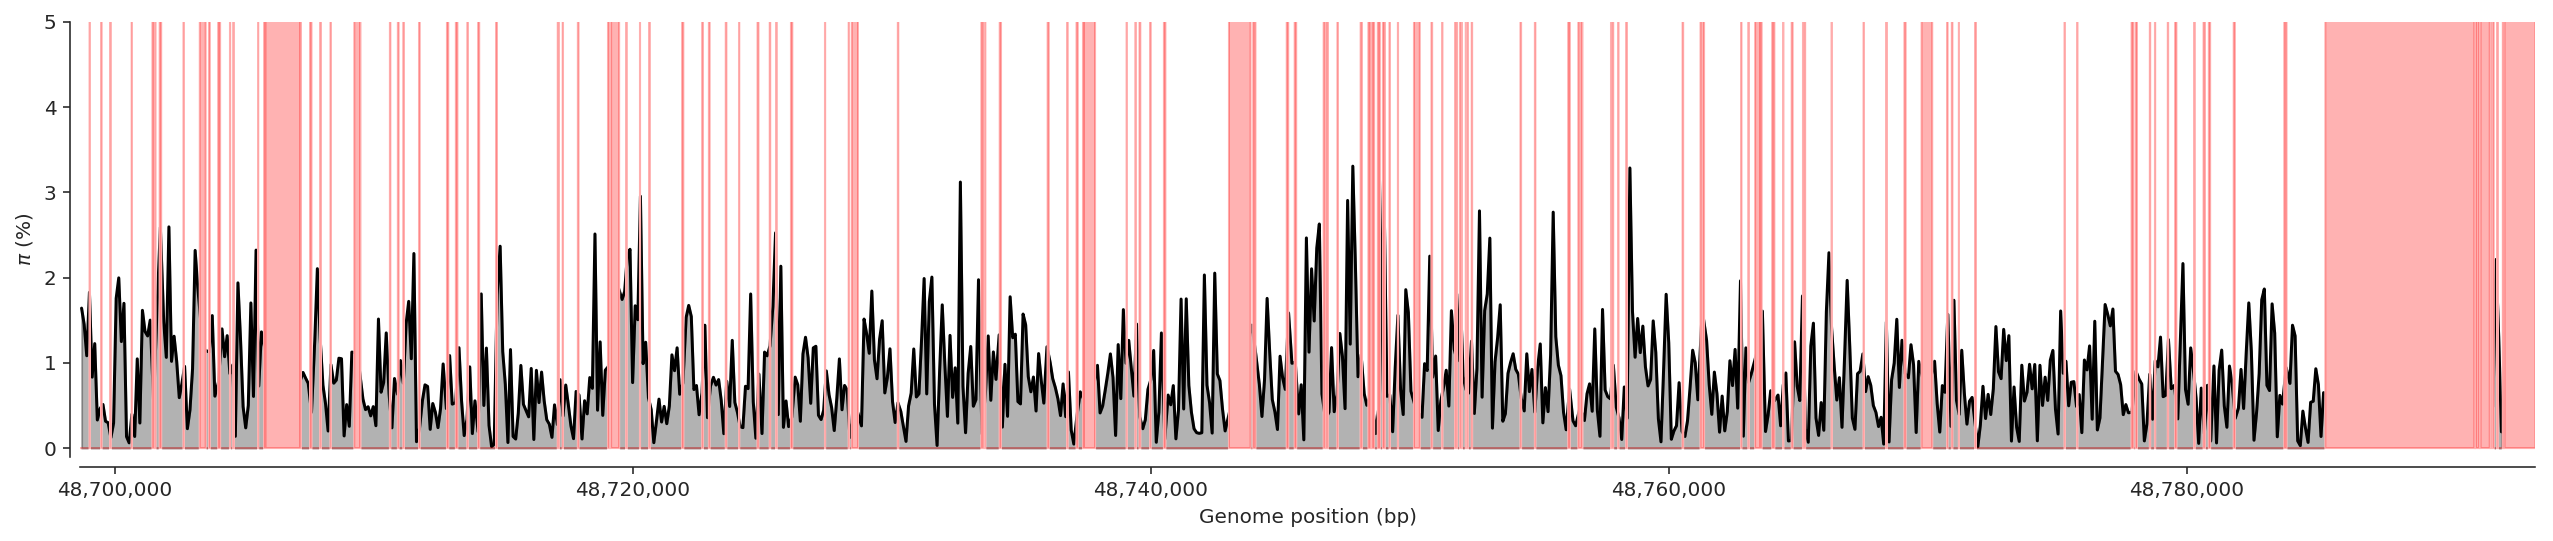

In [88]:
def plot_diversity_windowed_mean(xlim=dsx_region[1:], pops=populations, window_size=100, window_step=None):
    fig, ax = plt.subplots(figsize=(22, 4))
    sns.despine(ax=ax, offset=5)
    
    # plot diversity
    windows = allel.equally_accessible_windows(is_accessible, size=window_size, start=xlim[0], stop=xlim[1], step=window_step)
    x = windows.mean(axis=1)
    mpds = np.vstack([allel.mean_pairwise_difference(ac_dsx_pops[pop]) for pop in populations])
    mpd = np.mean(mpds, axis=0)
    y, _, _ = allel.windowed_statistic(pos_dsx, mpd, statistic=lambda v: np.sum(v) / window_size, windows=windows, fill=0)
    ax.fill_between(x, 0, y * 100, color='k', alpha=.3)
    ax.plot(x, y * 100, linestyle='-', marker=None, color='k')
    ax.set_ylabel('$\pi$ (%)')
    ax.set_xlabel('Genome position (bp)')
        
    # plot accessibility
    x = np.arange(xlim[0], xlim[1])
    y = (1 - is_accessible[xlim[0]-1:xlim[1]-1].astype('i1')) * 100
    y[y == 0] = -10
    ax.fill_between(x, -100, y, color='w', alpha=1, zorder=10)
    y[y < 0] = 0
    ax.fill_between(x, 0, y, color='r', alpha=.3, zorder=20)
    
    # tidy up
    ax.set_xlim(*xlim)
    ax.set_ylim(-0.1, 5)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
    
plot_diversity_windowed_mean()

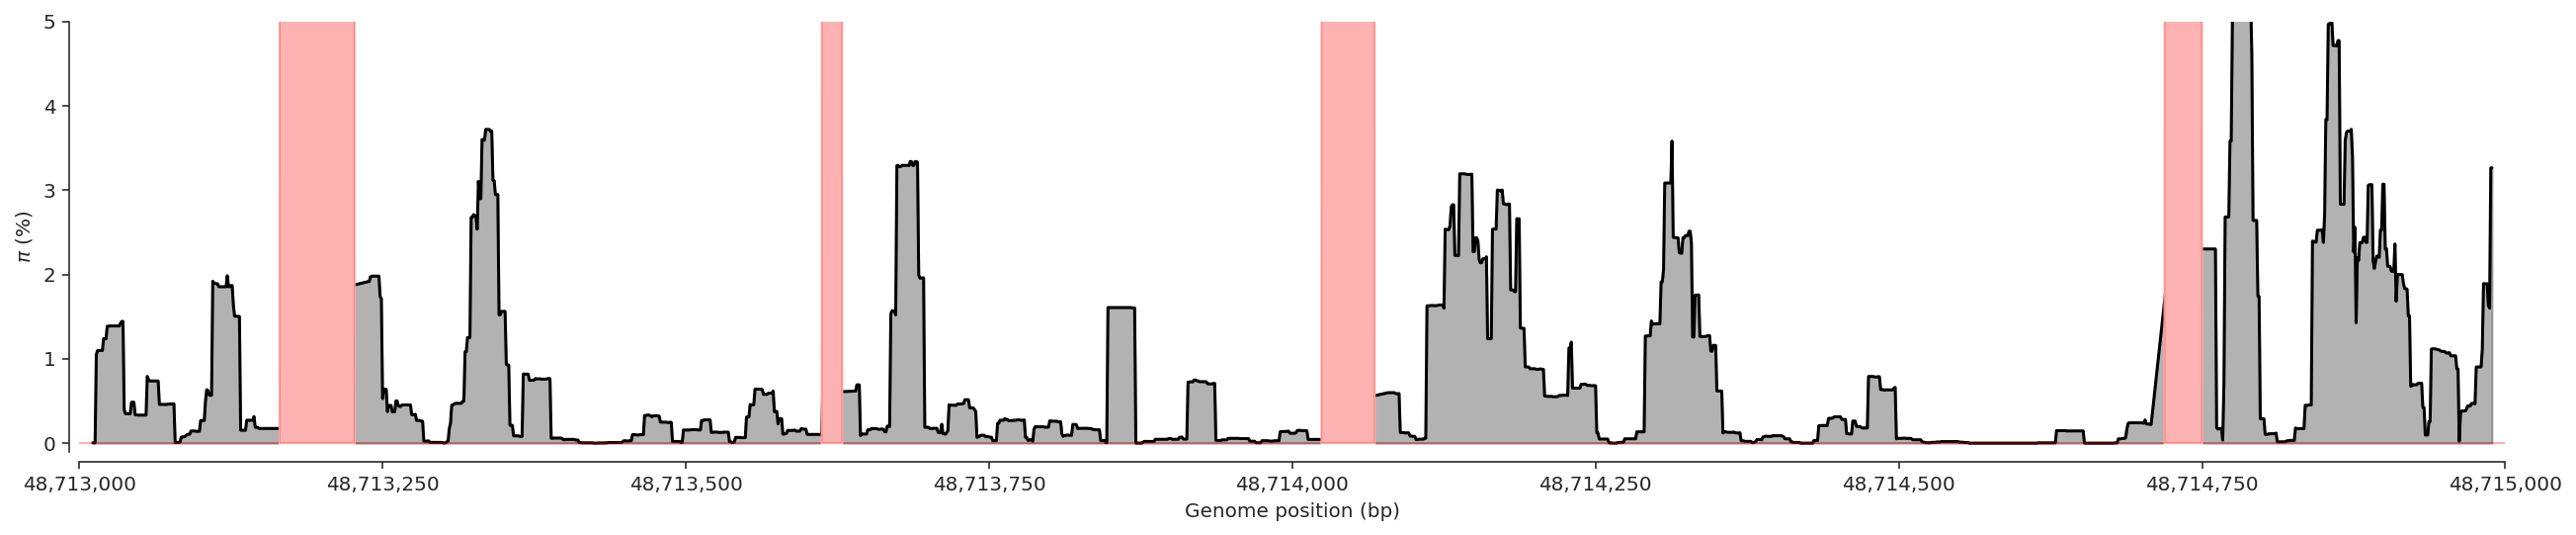

In [94]:
plot_diversity_windowed_mean(xlim=(48_713_000, 48_715_000), window_size=23, window_step=1)

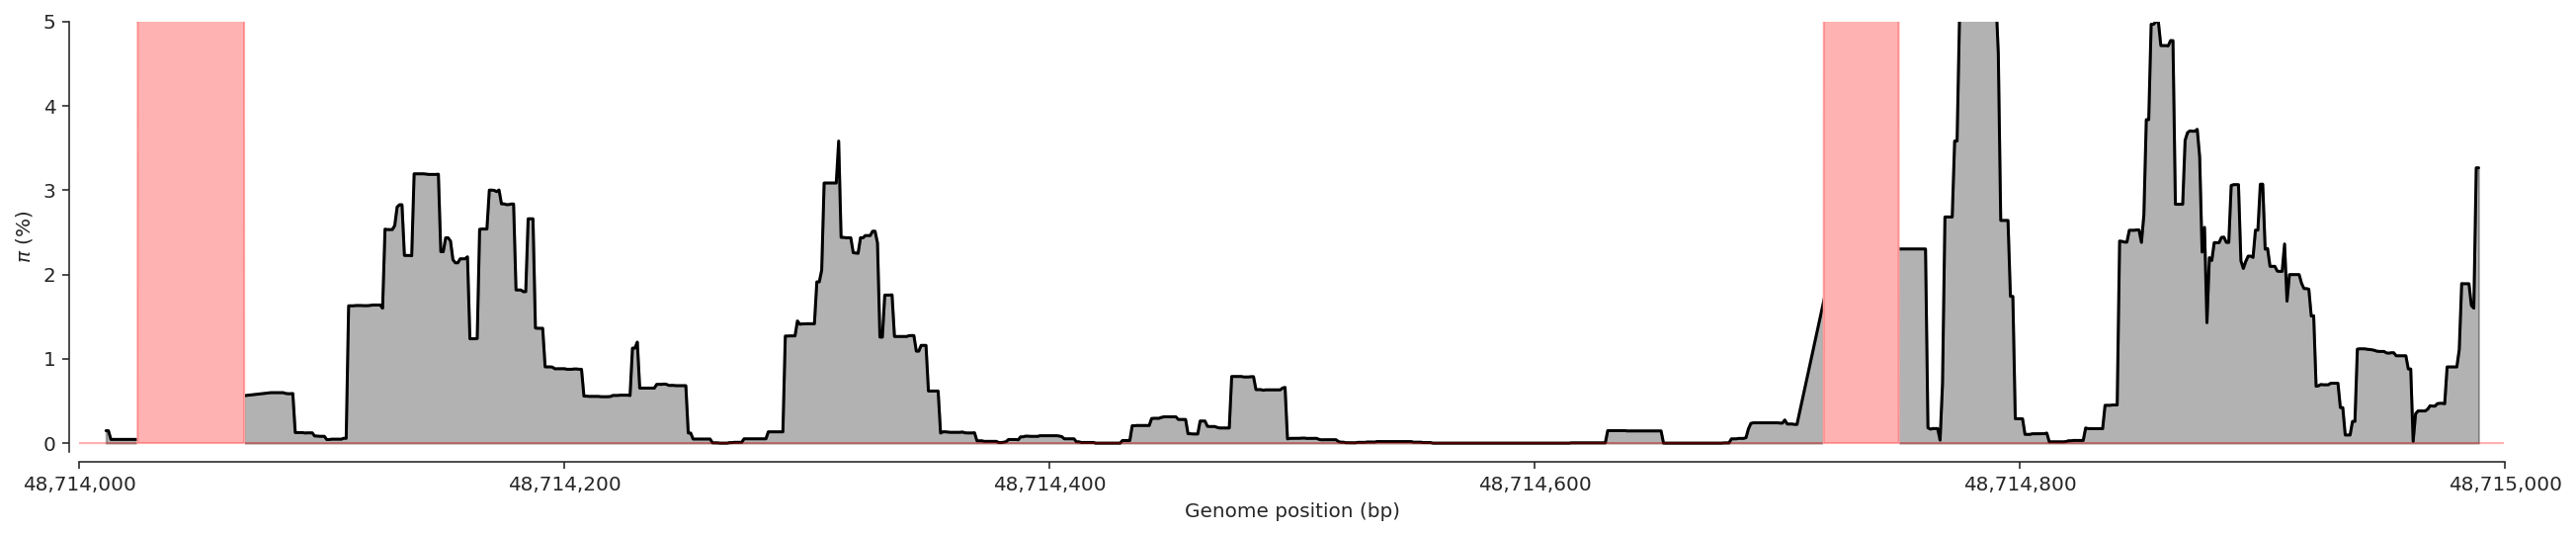

In [95]:
plot_diversity_windowed_mean(xlim=(48_714_000, 48_715_000), window_size=23, window_step=1)

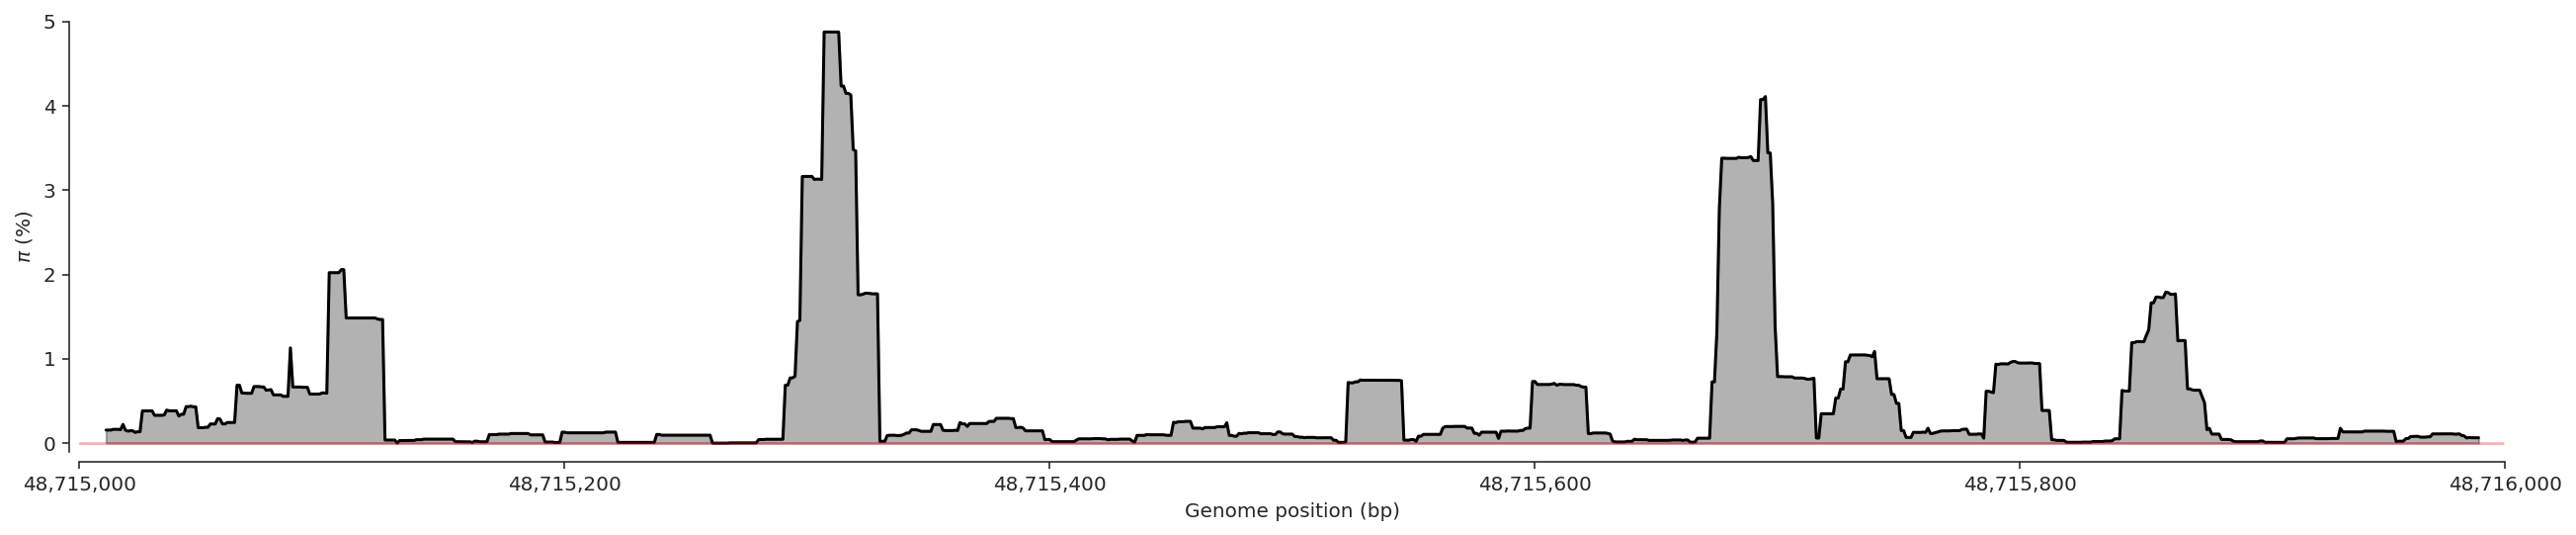

In [96]:
plot_diversity_windowed_mean(xlim=(48_715_000, 48_716_000), window_size=23, window_step=1)

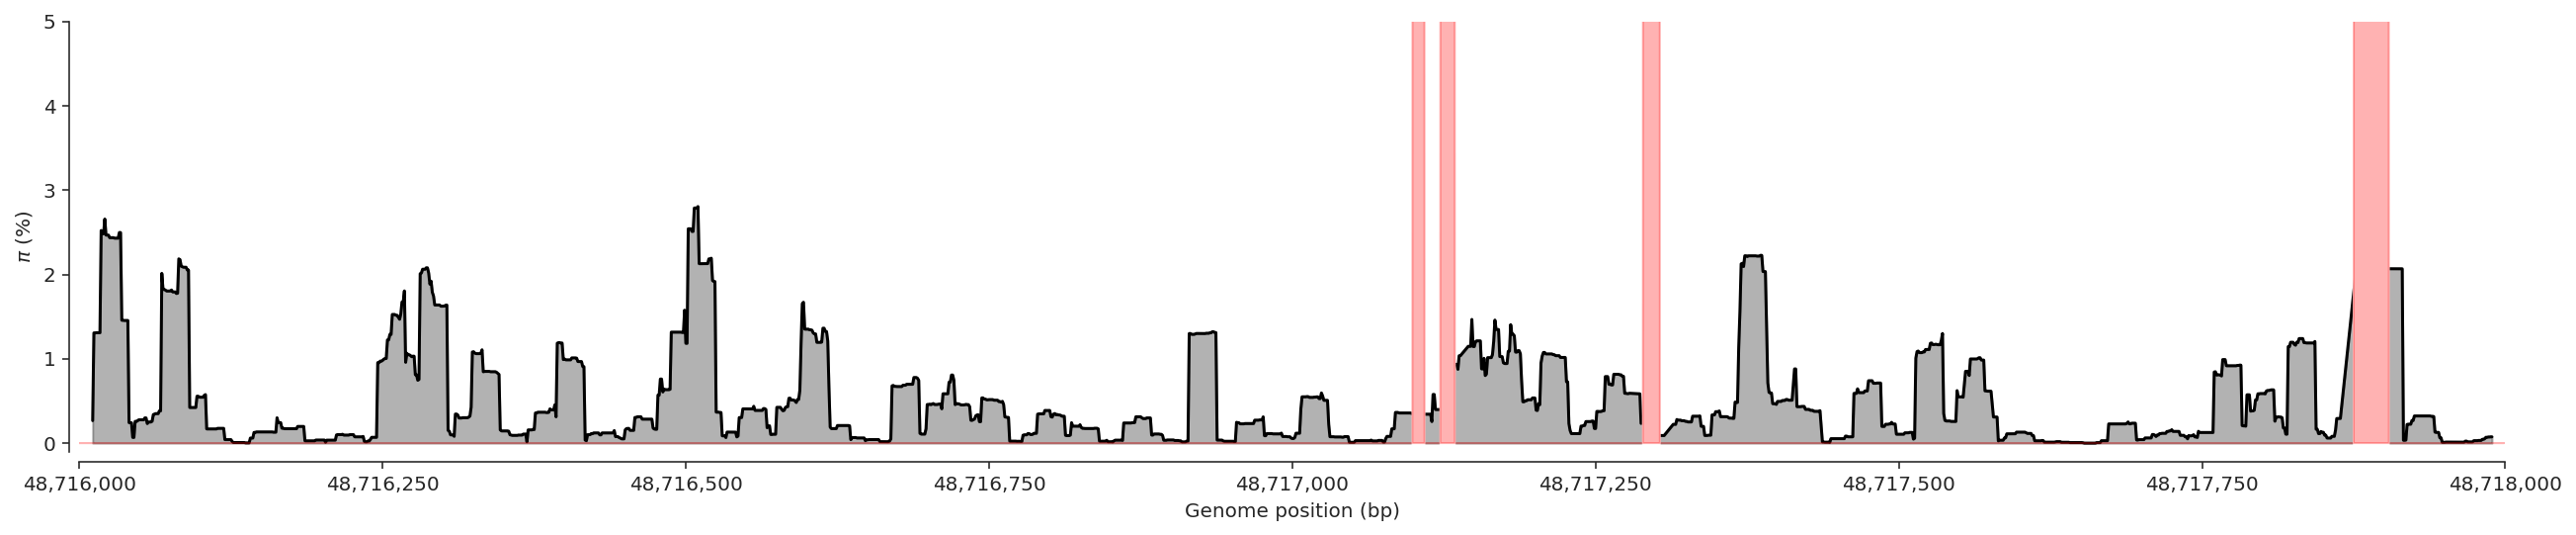

In [97]:
plot_diversity_windowed_mean(xlim=(48_716_000, 48_718_000), window_size=23, window_step=1)

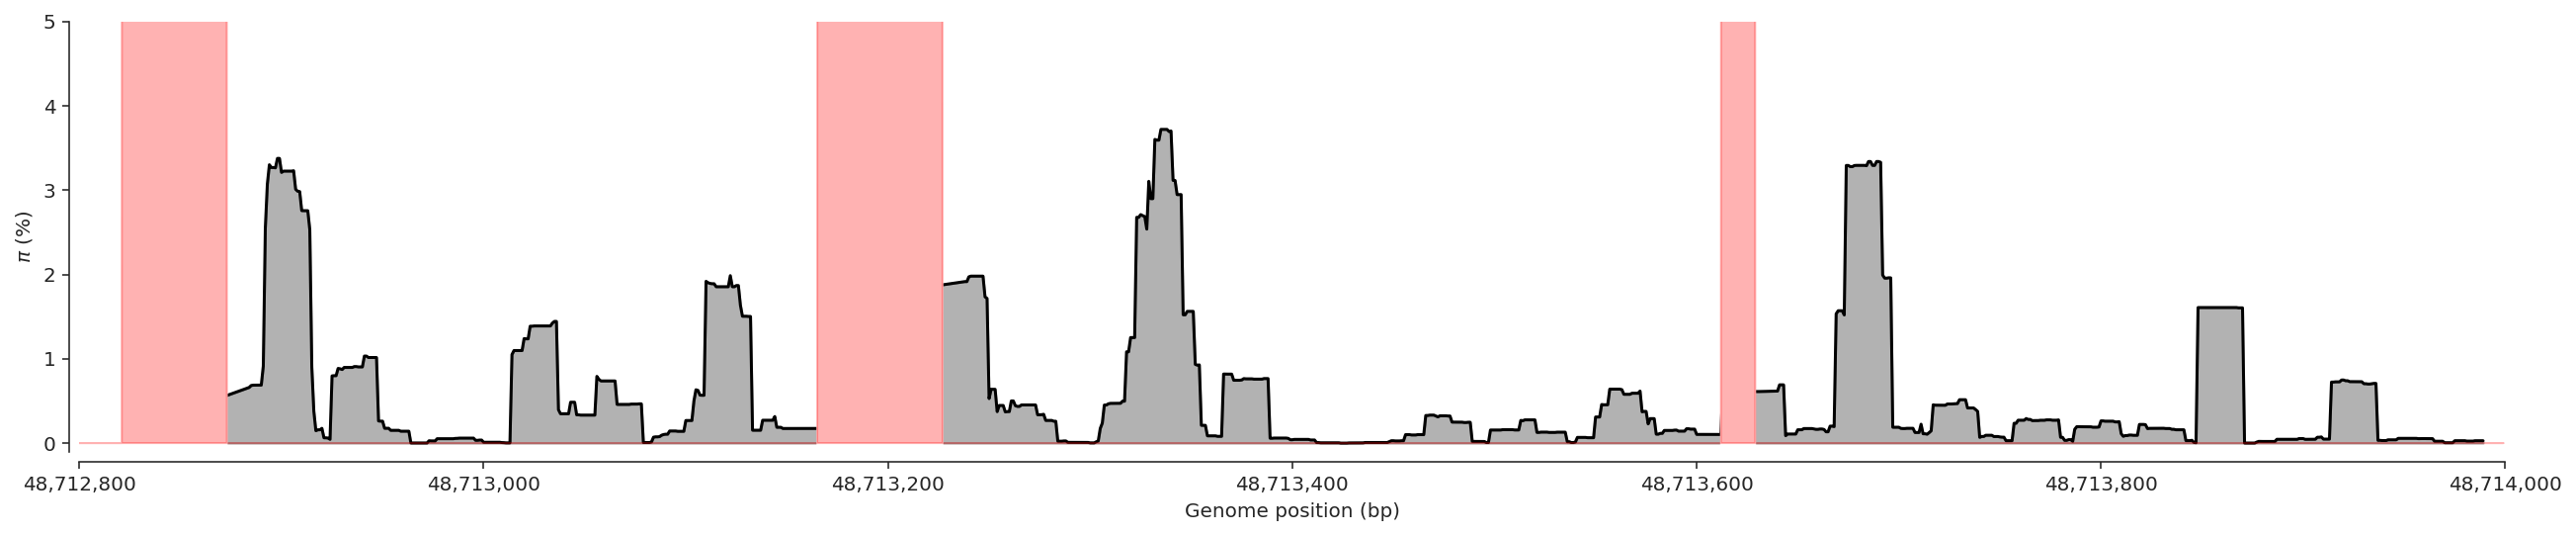

In [98]:
plot_diversity_windowed_mean(xlim=(48_712_800, 48_714_000), window_size=23, window_step=1)